# data visualization
In this notebook, SQL queries will be implemented to extract data based on specific filtering criteria. This data will then be read into Pandas dataframes, after which several visuals will be generated (based on the data) using Matplotlib. It's important to note that although these filters could be done by reading the full database into Pandas dataframes and then filtering, keeping the entire data filtering process within Python and Pandas/NumPy, PyMySQL will be used to extract specific data on a per-visual basis instead.

In [1]:
#datbase connector
import pymysql as pms
#local dataframe representations of data
import pandas as pd
#used for quick testing of concepts, but also for math
import numpy as np

# use for implementing custom modules
import sys
sys.path.insert(0, "./custom_modules/")

## grabbing data
The below function will be utilized again and again to connect to the database, execute a SQL query, extract a result into a Pandas dataframe, and close the database connection. But, first we need to read in the database credentials required for connecting to the MySQL client.

In [2]:
db_user = ""
db_pass = ""
db_name = ""
db_host = ""
db_charset = "utf8"
with open("database_credentials2.txt") as f:
    db_user = f.readline().strip()
    db_pass = f.readline().strip()
    db_name = f.readline().strip()
    db_host = f.readline().strip()

In [3]:
from dataframer import grab_data

## sample plot
This notebook will utilize [Seaborn](https://seaborn.pydata.org/index.html), a library built on top of [Matplotlib](https://matplotlib.org/), for data visualization. Below we use Seaborn to show the distribution of the Women's division's back squat, clean and jerk, deadlift, and snatch for those who competed in the 2018 CrossFit Open.

In [4]:
creds = [db_host, db_user, db_pass, db_name]

In [5]:
#extract data
womens_lifts_df = grab_data(
    """
    SELECT back_squat_lbs, clean_and_jerk_lbs, snatch_lbs, deadlift_lbs FROM athlete WHERE division_id=2 AND (
        back_squat_lbs > 0 AND
        clean_and_jerk_lbs > 0 AND
        snatch_lbs > 0 AND
        deadlift_lbs > 0
    );
    """,
    creds
)

In [6]:
#import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

### matplotlib styling

In [7]:
import seaborn_styler as sbs

In [8]:
sbs.stylize()

### plotting women's data

In [9]:
#show sample of data
womens_lifts_df.head(10)

,back_squat_lbs,clean_and_jerk_lbs,snatch_lbs,deadlift_lbs
0,282,207,190,315
1,225,165,137,290
2,245,155,125,300
3,300,231,200,365
4,315,220,175,355
5,225,170,135,305
6,210,160,110,335
7,315,220,169,352
8,230,180,130,350
9,255,185,160,315


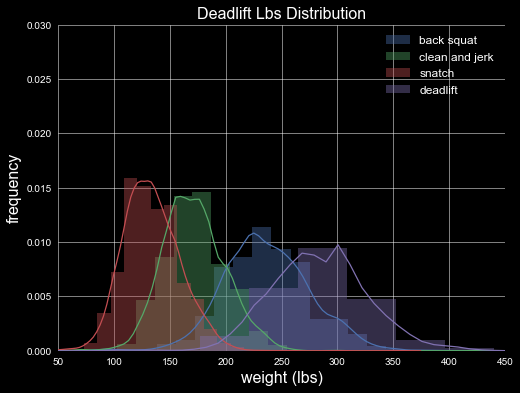

In [34]:
#plot each lift
for c in womens_lifts_df.columns:
    #fit plot
    #fit, ax = plt.subplots(facecolor = "black")
    sb.distplot(np.array(womens_lifts_df[c]), bins=30, label=c[:-4].replace("_", " "))
    #label axes and add to labels for legend
    plt.xlabel(c)
    #grid
    plt.grid(True)
    #title
    plt.title(c.replace("_", " ").title() + " Distribution")
#this is the same for all
plt.xlabel("weight (lbs)")
plt.ylabel("frequency")
#axes bounds
plt.axis([50, 450, 0, 0.03])
#legend (.get_frame().set_alpha() sets the backgroudn on the legend)
leg = plt.legend()
#for t in leg.get_texts():
#    t.set_color(sbs.font_color)
#plt.legend().get_frame().set_alpha(.95)
#show
plt.show()

## scoring athletes basedon performance
Athlete scoring has been written in a separate module called `scorer`. The scorer.py file can be found in this repo, and contains in-depth documentation of how athletes are evaluated. The scoring metric implemented in very similar (but not identical) to that of the CrossFit leaderboard.

One important thing to note is that the leaderboard function was written to reduce repetitive code as much as possible. Therefore, in order to avoid opening connections this notebook within `try` blocks and having to close them and monitor exceptions, the leaderboard expects to open the database connection on it's own.
Given this, the leaderboard function expects a list containing the required database credentials, where the order is the same as that of the `pms.connect()` parameter list in `grab_data()` (host, user, passwd, db, charset).

In [11]:
import importlib

# use for implementing custom modules
import sys
sys.path.insert(0, "./custom_modules/")

import scorer

In [12]:
open_keys = [
    "leaderboard_{}".format(c) for c in [
        "18_1_reps",
        "18_2_time_secs",
        "18_2a_weight_lbs",
        "18_3_time_secs",
        "18_4_time_secs",
        "18_5_reps"
    ]
]

### boy's 16-17 leaderboard
The below codeblock shows the requirements in order to request a leaderboard. Here, I've gone into the `division` table ahead of time and found that the Boy's (16-17) leaderboard has `id=16`.

In [13]:
#database credentials
creds = [db_host, db_user, db_pass, db_name, db_charset]
#may need to reimport scorer module if changing code inside it between runs
importlib.reload(scorer)
#boys open leaderboard
scorer.leaderboard(16, 0, ["id", "name"] + open_keys, creds).head(5)

,id,name,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,points
86,671093,DALLIN PEPPER,416,265,301,1073,576,147,40
78,655641,ZACH MAYER,392,298,307,1076,568,152,43
4,382282,DYLAN KADE,402,295,278,1076,572,152,72
369,901799,NICK TUNZI,384,305,322,1097,571,140,91
65,623552,VINCENT RAMIREZ,390,304,290,1057,546,135,91


## the difference between top ranges of athletes
The Open is meant to test general physical preparedness on an accessible level. Athletes send their scores in online, and are ranked according to how well they score based on their fellow in-division competitors. I'm going to plot the worst-performing and highest-performing range for each open leaderboard below. This range will outline the amount of variance between workouts at the highest end of competition. This range will be outlined and shaded.

Within this range, I'll also plot a select few lines, which are representative of select athletes' scores, or average scores for select athlete ranges (average of top 100 for example).

In [14]:
#use men's division for rest of notebook (athlete profiles tend to be more complete)
working_division_id = 1
working_leaderboard = scorer.leaderboard(working_division_id, 0, ["id", "name"] + open_keys, creds)
working_leaderboard.head(5)

,id,name,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps,points
3127,153604,MATHEW FRASER,476,242,380,852,399,198,95
3523,180541,ALEX VIGNEAULT,472,258,382,952,408,179,422
11459,702092,WILLY GEORGES,460,257,364,892,501,188,551
6039,308712,JEAN-SIMON ROY-LEMAIRE,468,238,346,952,463,178,608
3198,158264,PATRICK VELLNER,476,246,343,851,409,174,613


<img src="images/mens_leaderboard_comparison.png" />

The following function is used as a helper to turn data from Pandas dataframes into MySQL parseable queries. Note that again, it'd just be easier to do this in Pandas, but I'm trying to increase my SQL utility.

In [15]:
from dataframer import grab_top_n_summarizer_data

### filtering the data
Let's grab the data corresponding to the top athletes from the database. We'll do this by filtering athletes based on IDs in the men's leaderboard.

In [16]:
ranges = [10, 250, 5000]
funcs = ["MIN", "MAX", "AVG"]
#resulting dataframes are ordered as follows:
#[top10min, top10max, top10avg, top100min, ...]
result = [grab_top_n_summarizer_data(n, working_division_id, f, working_leaderboard, creds)
              for n in ranges for f in funcs]

In [17]:
result[0]

,MINtop10 18_1_reps,MINtop10 18_2_time_secs,MINtop10 18_2a_weight_lbs,MINtop10 18_3_time_secs,MINtop10 18_4_time_secs,MINtop10 18_5_reps
0,441,229,342,846,399,171


### plotting the top 10 ([source](https://matplotlib.org/examples/pylab_examples/fill_between_demo.html))
Below the data is plotted 

C:\Users\unknown\AppData\Local\conda\conda\envs\crossfit_open_2018\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


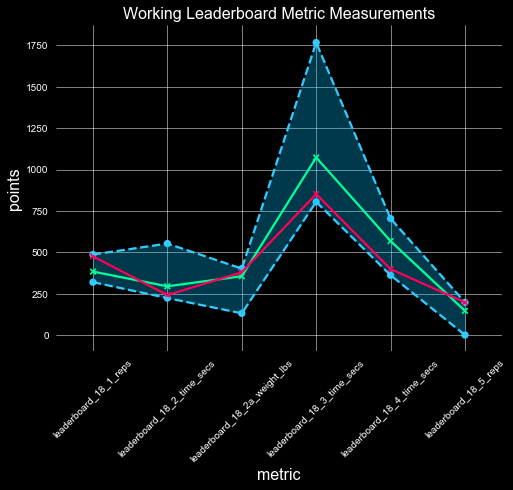

In [38]:
#colors for [lo bounds, lo specific, lo shade, mid bounds, ...]
highlight_colors = ["#ff0059", "#00ff99"]
bounding_colors = ["#33ccff", "#00bbff"]
marker = "x"

#plot specific athletes' data
working_measure_columns = [c for c in working_leaderboard.columns
                               if c.endswith("secs") or c.endswith("reps") or c.endswith("lbs")]
working_athletes = [pd.DataFrame(working_leaderboard.iloc[i][working_measure_columns]).transpose()
                        for i in [0, 1000]]

#plot range of top athletes
for i in [6,7]:
    sb.pointplot(data=result[i], color=bounding_colors[0], linestyles=["--"], markersize=60)

#shading
xlim = int(plt.xlim()[1]) + 1
fill_range = np.array([i for i in range(xlim)])
plt.fill_between(
    fill_range,
    result[6].values[0],
    result[7].values[0],
    color=bounding_colors[1],
    alpha=.3
)

#plot each athlete
for i in range(len(working_athletes)):
    sb.pointplot(
        data=working_athletes[len(working_athletes) - 1 - i],
        color=highlight_colors[len(highlight_colors) - 1 - i],
        markers=marker
        #scale=1
    )
    plt.xlabel(working_leaderboard.iloc[i]["name"])

plt.xlabel("metric")
plt.ylabel("points")
plt.title("Working Leaderboard Metric Measurements")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [20]:
working_athletes[0]

,leaderboard_18_1_reps,leaderboard_18_2_time_secs,leaderboard_18_2a_weight_lbs,leaderboard_18_3_time_secs,leaderboard_18_4_time_secs,leaderboard_18_5_reps
3127,476,242,380,852,399,198


## the impact of height and weight
One of CrossFit's biggest appeals is that anybody can do it. Whether you're old or young, fat or thin, tall or short, there's usually a scalable alternative to some movement. However, one of the sport's biggest criticisms is that within specific divisions, there's no weight class. Divisions solely split up athletes based on gender and age. Because we have the data, we can see the impact variables like height and weight have on Open scoring.

Below we'll show a heatmap representation of this data. [But first](https://www.youtube.com/watch?v=kdemFfbS5H0&feature=youtu.be&t=36s), let's look at a distribution of the height and weight data.

### grabbing height/weight data from the working table

In [21]:
height_weight_points = working_leaderboard[["id", "name", "points"]].merge(
    grab_data(
        """
            SELECT id, height_in, weight_lbs FROM athlete
                WHERE id IN ({}) AND
                height_in >= 50 AND
                height_in <= 84 AND
                weight_lbs >= 100 AND
                weight_lbs <= 300;
        """
        .format(
            ", ".join([str(x) for x in list(working_leaderboard["id"])])
        ),
        creds
    )
)

In [22]:
height_weight_points.head(5)

,id,name,points,height_in,weight_lbs
0,153604,MATHEW FRASER,95,67,190
1,180541,ALEX VIGNEAULT,422,71,208
2,702092,WILLY GEORGES,551,70,190
3,308712,JEAN-SIMON ROY-LEMAIRE,608,69,195
4,158264,PATRICK VELLNER,613,71,195


### plotting the distributions

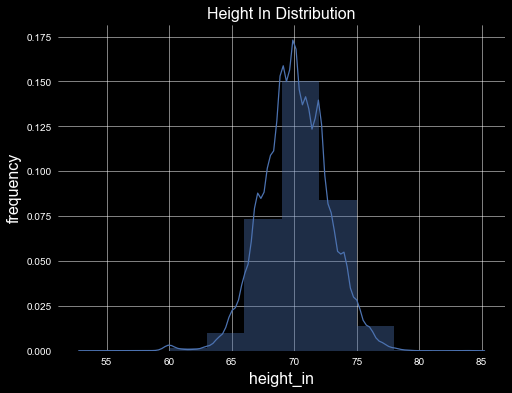

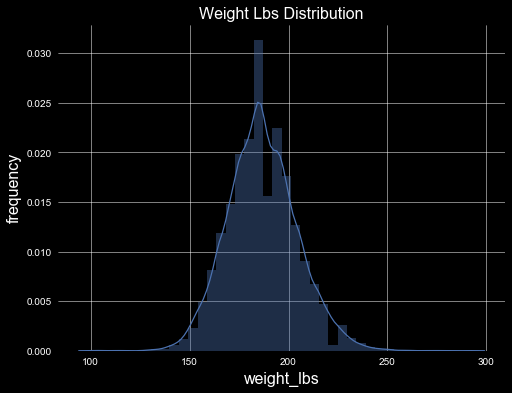

In [23]:
height_weight_cols = ["height_in", "weight_lbs"]
#height_weight_axis_ranges = [[50, 100, 0, 3000], [50, 300, 0, 2000]]
height_weight_bins = [10, 40]
#plot each lift
for i in range(len(height_weight_cols)):
    #fit plot
    sb.distplot(
        np.array(height_weight_points[height_weight_cols[i]]),
        bins=height_weight_bins[i],
        label=c[:-4].replace("_", " "),
        hist_kws = {
            "normed": True
        }
    )
    #label axes and add to labels for legend
    plt.xlabel(height_weight_cols[i])
    #grid
    plt.grid(True)
    #title
    plt.title(height_weight_cols[i].replace("_", " ").title() + " Distribution")
    #axis display range
    #plt.axis(height_weight_axis_ranges[i])
    #showing/labeling
    plt.xlabel(height_weight_cols[i])
    plt.ylabel("frequency")
    plt.show()

### partitioning the height/weight data into bins
The below function abstracts the specific logic for height/weight partitioning into a more generalized form, allowing us to create partitions for *any* dataframe with 2 numeric columns to plot against *any* numeric predictor column.

In [24]:
def get_data_for_heatmap(c1, bins1, c2, bins2, vals, df, min_entries=0, return_mask=True):
    """
    For a given dataframe with 2 numeric columns c1 and c2,
    this function will
        1. Partition c1 into bins1 and c2 into bins2 partitions
        2. Split each row from df into 1 of both the bins1 x bins2
            categorical assignments
        3. Average the values of the vals column for members in a
            a specific i,j referencing (some bins1, bins2 assignment)
        4. Convert the aggregated data of i,j,k
            (bins1 assignment, bins2 assignment, vals assignment) into
            a dataframe
        5. If remove_invalid is True, remove any values with an average
            specified by -1, which occurs when some (bin1_i, bin2_j)
            filter has no entries
        6. Return dataframe (pivoted version)
    If min entries is specified > 0, then when a specific filter
    produces less than min entries rows, the filter (bin1_i, bin2_j)
    will not have an average.
    """
    #data
    data = []
    #partitions
    parts = []
    #columns and bins
    cols = [c1, c2]
    bins = [bins1, bins2]
    #print(cols)
    #print(bins)
    #create partitions
    for i in range(len(cols)):
        parts.append(
            pd.cut(
                df[cols[i]], bins[i], retbins=True
            )[1]
        )
    #round partitions to 1 decimal place
    for i in range(len(parts)):
        for j in range(len(parts[i])):
            parts[i][j] = round(parts[i][j], 1)
    
    print(parts[0])
    print(parts[1])
    #aggregate vals averages
    for i in range(len(parts[0]) - 1):
        for j in range(len(parts[1]) - 1):
            #filtered values columns
            filtered = df[
                        #leftbound(1) < col1 and col1 <= rightbound(1)
                        (parts[0][i] <= df[cols[0]]) & (df[cols[0]] < parts[0][i+1])
                        &
                        #leftbound(2) < col2 and col2 <= rightbound(2)
                        (parts[1][j] <= df[cols[1]]) & (df[cols[1]] < parts[1][j+1])
            ][vals]
            mean = -1
            #produce mean if desired
            if min_entries <= len(filtered):
                #cant convert to integer for case when min_entries is 0
                mean = round(np.mean(filtered), 0)
                if 0 < min_entries:
                    mean = int(mean)

            #append data
            data.append(
                [
                    #column 1 ranges (categorical)
                    "({}, {}]".format(str(int(parts[0][i])).zfill(4), str(int(parts[0][i+1])).zfill(4)),
                    #column 2 ranges (categorical)
                    "({}, {}]".format(str(int(parts[1][j])).zfill(4), str(int(parts[1][j+1])).zfill(4)),
                    #mean
                    mean
                ]
            )

    #return data
    result_df = pd.DataFrame(data, columns=[c1, c2, vals]).pivot(c1, c2, vals)
    if not return_mask:
        return result_df
    
    #if mask desired, produce
    mask = np.zeros_like(result_df.values)
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            mask[i][j] = 0 if result_df.values[i][j] != -1 else 1
    return result_df, mask

### heatmapping height, weight, and Open points
Now that the we have the function, lets apply it to height/weight and these variables' relationships with Open points.

[ 54.  57.  60.  63.  66.  69.  72.  75.  78.  81.  84.]
[ 101.8  120.9  139.8  158.7  177.6  196.5  215.4  234.3  253.2  272.1
  291. ]


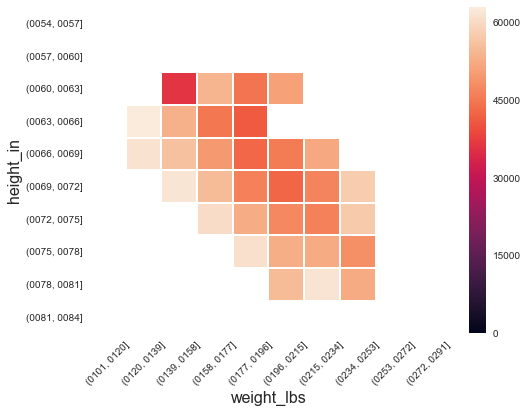

In [25]:
#grab data for heatmap
height_weight_heatmap_df, height_weight_heatmap_mask = get_data_for_heatmap(
    height_weight_cols[0], 10,
    height_weight_cols[1], 10,
    "points",
    height_weight_points,
    min_entries=5,
    return_mask=True
)
#do this to customize figure size
#fig, ax = plt.subplots()
#fig.set_size_inches(
#plot heatmap
#sb.heatmap(height_weight_heatmap_df, annot=True, fmt=".2f", linewidths=.5)
with sb.axes_style("white"):
    sb.heatmap(height_weight_heatmap_df, mask=height_weight_heatmap_mask, annot=False, linewidths=1)
    plt.xticks(rotation=45)
    plt.show()

### applying heatmaps to other leaderboards
A benchmark CrossFit workout is Fran. The workout scheme is as follows 21 thrusters, 21 pullups, 15 thrusters, 15 pullups, 9 thrusters, 9 pullups, or
* 21, 15, 9
    * thrusters
    * pullups
To some extent, you thruster and pullup strength could be associated with your clean and jerk (afterall, your thruster is just a clean and jerk without the pull from the floor, and your clean strength could loosely translate to pulling power). Additionally, because Fran is so fast and intense, the speed requirement is similar to that of a 400-800m sprint.

Let's see if there's any type of relationship between clean and jerk strength, 400m sprint times, and Fran scores.

In [26]:
#get custom leaderboard
cj_400_fran = working_leaderboard[["id", "name",]].merge(
    grab_data(
        """
            SELECT id, clean_and_jerk_lbs as cj, sprint_400_m_time_secs as 400m, fran_time_secs as fran
                FROM athlete WHERE
                    id IN ({}) AND
                    clean_and_jerk_lbs >= 45 AND
                    clean_and_jerk_lbs <= 600 AND
                    sprint_400_m_time_secs >= 40 AND
                    sprint_400_m_time_secs <= 120 AND
                    fran_time_secs < 300 AND
                    fran_time_secs > 60;
        """
        .format(
            ", ".join([str(x) for x in list(working_leaderboard["id"])])
        ),
        creds
    )
)
print("Entries: {}".format(len(cj_400_fran)))
cj_400_fran.head(5)

Entries: 2070


,id,name,cj,400m,fran
0,158264,PATRICK VELLNER,355,66,134
1,20698,TIM PAULSON,365,61,135
2,21292,GARRET FISHER,385,55,129
3,571999,R. PAUL CASTILLO,335,66,138
4,105536,CHASE SMITH,350,56,145


In [27]:
cj_400_fran_heatmap_df, cj_400_fran_mask = get_data_for_heatmap(
    "cj", 10, "400m", 8, "fran", cj_400_fran, min_entries=5, return_mask=True
)
cj_400_fran_heatmap_df

[  94.7  126.2  157.4  188.6  219.8  251.   282.2  313.4  344.6  375.8
  407. ]
[  39.9   50.    60.    70.    80.    90.   100.   110.   120. ]


400m,"(0039, 0050]","(0050, 0060]","(0060, 0070]","(0070, 0080]","(0080, 0090]","(0090, 0100]","(0100, 0110]","(0110, 0120]"
cj,,,,,,,,
"(0094, 0126]",-1,-1,-1,-1,-1,-1,-1,-1
"(0126, 0157]",-1,-1,-1,-1,-1,-1,-1,-1
"(0157, 0188]",-1,-1,-1,-1,-1,-1,-1,-1
"(0188, 0219]",-1,177,260,206,-1,-1,-1,-1
"(0219, 0251]",192,206,202,207,212,224,216,-1
"(0251, 0282]",189,179,182,190,196,202,-1,-1
"(0282, 0313]",166,162,168,180,189,183,-1,-1
"(0313, 0344]",157,149,153,158,179,175,-1,-1
"(0344, 0375]",-1,139,144,153,-1,-1,-1,-1


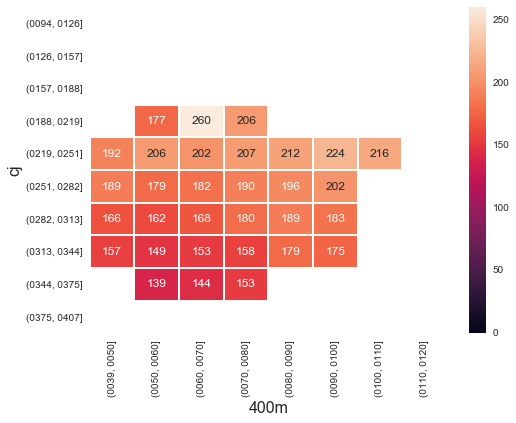

In [28]:
with sb.axes_style("white"):
    sb.heatmap(
        cj_400_fran_heatmap_df,
        mask=cj_400_fran_mask,
        fmt="0",
        annot=True,
        linewidth=1
    )

## overlapping densities in weightlifting
Because of CrossFit's scalability, weight for specific metcons usually varies between divisions (on average). However, metrics which measure pure strength are easy to compare against one another. Let's use a [joy plot](https://seaborn.pydata.org/examples/kde_joyplot.html) from the Seaborn library to show the density distribution for all male divisions for CrossFit's athlete profile lifts: snatch, clean and jerk, back squat, and deadlift.

### grab the men's data

In [29]:
mens_lifts = grab_data(
    """
        SELECT
            a.id as id,
            division,
            d.id as 'division id',
            snatch_lbs as snatch,
            clean_and_jerk_lbs as 'clean and jerk',
            back_squat_lbs as squat,
            deadlift_lbs as deadlift
        FROM athlete AS a
        INNER JOIN division AS d
        ON a.division_id = d.id
        WHERE
            division_id IN (1, 3, 5, 7, 9, 12, 14, 16, 18) AND
            snatch_lbs > 0 AND
            snatch_lbs < 600 AND
            clean_and_jerk_lbs > 0 AND
            clean_and_jerk_lbs < 700 AND
            back_squat_lbs > 0 AND
            deadlift_lbs > 0;
    """,
    creds
)
mens_lifts.head(5)

,id,division,division id,snatch,clean and jerk,squat,deadlift
0,88,Men,1,265,315,455,518
1,1655,Men,1,280,365,462,575
2,1690,Men,1,280,347,475,555
3,1718,Men,1,305,365,500,570
4,1721,Men,1,308,375,500,506


### retargeting the data
Although any of these individual lifts will do, we'll be plotting the olympic total. This is comprised of the sum of the snatch and clean and jerk.

In [30]:
mens_totals = pd.DataFrame(mens_lifts.drop(["squat", "deadlift"], axis=1))
mens_totals["total"] = mens_totals["snatch"] + mens_totals["clean and jerk"]
mens_totals = mens_totals.drop(["snatch", "clean and jerk"], axis=1)
mens_totals.head(5)

,id,division,division id,total
0,88,Men,1,580
1,1655,Men,1,645
2,1690,Men,1,627
3,1718,Men,1,670
4,1721,Men,1,683


### plotting men's olympic total distribution
Below we use the previously mentioned joy plot to plot the different men's divisions olympic total distributions. This plot is based off of [this example](https://seaborn.pydata.org/examples/kde_joyplot.html).

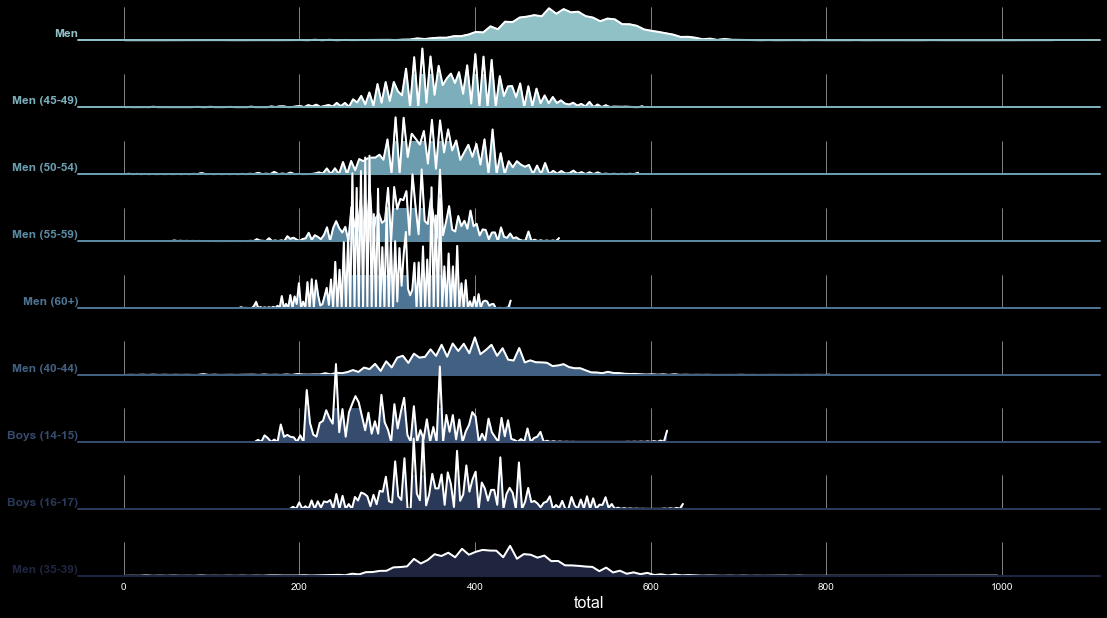

In [31]:
#initialize facetgrid
pal = sb.cubehelix_palette(9, rot=-.25, light=.7)
facetgrid = sb.FacetGrid(mens_totals, row="division", hue="division", aspect=15, size=1, palette=pal)

#draw densities
facetgrid.map(sb.kdeplot, "total", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
facetgrid.map(sb.kdeplot, "total", clip_on=False, color="w", lw=2, bw=.2)
facetgrid.map(plt.axhline, y=0, lw=2, clip_on=False)

#define function for labeling in axes coordinates
def custom_label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="right", va="center", transform=ax.transAxes)

facetgrid.map(custom_label, "total")

#set plots to overlap
facetgrid.fig.subplots_adjust(hspace=1)

#remove axes details
facetgrid.set_titles("")
facetgrid.set(yticks=[])
facetgrid.despine(bottom=True, left=True)
plt.show()